<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Text-Preprocessing" data-toc-modified-id="Text-Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Text Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Load-Datasets-and-Quick-Examination" data-toc-modified-id="Load-Datasets-and-Quick-Examination-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load Datasets and Quick Examination</a></span></li><li><span><a href="#Check-Missing-Values" data-toc-modified-id="Check-Missing-Values-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check Missing Values</a></span></li><li><span><a href="#Further-Examine-the-Data-and-Create-a-Data-Cleaning-Strategy" data-toc-modified-id="Further-Examine-the-Data-and-Create-a-Data-Cleaning-Strategy-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Further Examine the Data and Create a Data Cleaning Strategy</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li><li><span><a href="#Train/Test-Split" data-toc-modified-id="Train/Test-Split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train/Test Split</a></span></li><li><span><a href="#Text-Feature-Extraction" data-toc-modified-id="Text-Feature-Extraction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Text Feature Extraction</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Build-Multi-Label-Classifier" data-toc-modified-id="Build-Multi-Label-Classifier-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Build Multi-Label Classifier</a></span></li></ul></li><li><span><a href="#Advanced-Feature-Engineering:-Word2Vec" data-toc-modified-id="Advanced-Feature-Engineering:-Word2Vec-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Advanced Feature Engineering: Word2Vec</a></span></li></ul></div>

# Text Preprocessing

In [1]:
# necessary libraries
import pandas as pd
import numpy as np
import re

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# for NLP tasks
import spacy
nlp = spacy.load("en_core_web_sm")
import nltk

# for feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# for model building
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

## Load Datasets and Quick Examination

In [2]:
# load training set
df = pd.read_csv('train.csv')

**labeled vs. nonlabeled**
- For training dataset, each row represents a comment with a unique id and 6 binary labels: toxic, sever toxic, obscene, threat, insult, identity hate.
- Each comment can have multiple labels or no label at all, depending on whether it contains toxic messages.

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**imbalanced dataset**
- The dataset is imbalanced with 90% nonlabeled and 10% labeled. 

In [4]:
# Create a new category indicating non-labeled data
# 1 being qualified, 0 being non-qualified
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['nontoxic'] = 1- df[label_cols].max(axis=1)
df['nontoxic'].value_counts(normalize=True)

1    0.898321
0    0.101679
Name: nontoxic, dtype: float64

## Check Missing Values

**no missing value observed**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
nontoxic         159571 non-null int64
dtypes: int64(7), object(2)
memory usage: 11.0+ MB


## Further Examine the Data and Create a Data Cleaning Strategy

**Examination on non-toxic examples**

In [6]:
print (df['nontoxic'][1])
df['comment_text'][1]

1


"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [7]:
print (df['nontoxic'][3])
df['comment_text'][3]

1


'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [8]:
print (df['nontoxic'][5])
df['comment_text'][5]

1


'"\n\nCongratulations from me as well, use the tools well. \xa0· talk "'

In [9]:
print (df['nontoxic'].iloc[-1])
df['comment_text'].iloc[-1]

1


'"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead of helping rewrite them.   "'

**Examination on toxic examples**

In [10]:
toxic = df.loc[df['nontoxic'] == 0]

In [11]:
toxic = toxic.reset_index(drop=True)

In [12]:
print (toxic.iloc[1, 1])

Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


In [13]:
print (toxic.iloc[5, 1])

I'm Sorry 

I'm sorry I screwed around with someones talk page.  It was very bad to do.  I know how having the templates on their talk page helps you assert your dominance over them.  I know I should bow down to the almighty administrators.  But then again, I'm going to go play outside....with your mom.   76.122.79.82


In [14]:
print (toxic.iloc[-2, 1])

"

Hey listen don't you ever!!!! Delete my edits ever again I'm annoyed because the WWE 2K15 a few of the roster have been confirmed and your stupid ass deletes what I write. just stop!!!! Please STOP!!!! You don't work 2k or WWE games so stop deleting other peoples shit if I get it wrong or others get it wrong let them they will get the hang of it eventually but don't stick your most ass in their and I'm gonna delete the ""please do not insert the roster"" shit how do you not have it if has been confirmed!!!!! God your stupid."


### Context Review:
**What data cleaning task should be applied for this dataset?**
- There are no obvious spelling mistakes observed.
- There are HTML tags and newline characters.
- Contractions, shortened version of words and phrases, are commonly used, since we're dealing with online comments.

**Any extra information?**
- For some comments, the userID and post time of commenter are shown.

**What issues appeared frequently?**
- Complains about comments or edits being erased
- Topics related to WWII, religious etc.

**Any interesting user behaviors?**
- Toxic keywords are often typed in UPPER CASE with special characters to enhance commenters' anger.
- Toxic keywords are often used as Nouns or Verbs.


In [15]:
# Remove HTML tags
from bs4 import BeautifulSoup
def remove_html(text):
    return BeautifulSoup(text, "html.parser").text

In [16]:
# Expand contractions
# Leverage the contractions module, contributed by Dipanjan Sarkar
from contractions import CONTRACTION_MAP

In [17]:
# Expand contractions
# Leverage the contractions module, contributed by Dipanjan Sarkar
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [18]:
# remove new line characters
def remove_newline(text):
    return text.replace('\n',' ')

In [19]:
# remove special characters, such as escape characters and punctuations
def remove_special_chars(text, remove_digit = False):
    if remove_digit:
        return  re.sub(r"[^a-zA-Z ]"," ",text)
    else:
        return re.sub(r"[^\w\s]"," ",text)

In [20]:
# remove extra whitespaces
def remove_extra_spaces(text):
    return " ".join(text.split())

In [21]:
# clean text function
def clean_corpus(corpus, html_stripping = True, contractions_fix = True, 
                newline_removal = True, special_chars_removal= True,
                extra_spaces_removal = True):
    # remove HTML tags
    if html_stripping:
        doc = remove_html(corpus)
    # expand contractions
    if contractions_fix:
        doc = expand_contractions(doc)
    # remove new line
    if newline_removal:
        doc = remove_newline(doc)
    # remove special characters
    if special_chars_removal:
        doc = remove_special_chars(doc, remove_digit = False)
    # remove extra white spaces
    if extra_spaces_removal:
        doc = remove_extra_spaces(doc)
    return doc

In [22]:
df['clean_comment'] = df['comment_text'].apply(clean_corpus)

/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "http://en.wikipedia.org/wiki/Wikipedia_talk:No_original_research/archive15#YouTube_art_as_primary_source" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "http://finance.yahoo.com/news/7-fascinating-nuggets-another-bewildering-150348488.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "http://en.wikipedia.org/wiki/Wikipedia:ELYES" looks like a URL. Beautiful Soup is not an HTTP client

In [23]:
# calculate how many words are all capitals
def all_caps(text):
    return (sum(1 for t in text.split() if t.isupper()))
df['num_allcaps'] = df['comment_text'].apply(all_caps)

In [24]:
# # lemmatize words
# def lemmatizer(text):
#     doc = nlp(text)
#     lemma_list = []
#     for token in doc:
#         if token.lemma_ == "-PRON-":
#             lemma_list.append(token.text)
#         else: 
#             lemma_list.append(token.lemma_)
#     return ' '.join(lemma_list)

In [25]:
# remove stopwords
from nltk import word_tokenize
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english')) 
def remove_stopword(text):
    result = [t for t in word_tokenize(text.lower()) if t not in stopwords]
    return ' '.join(result)

In [26]:
# normalize the corpus 
def normalize_corpus(corpus, stopword_removal = True):
    if stopword_removal:
        doc = remove_stopword(corpus)
    return doc

In [27]:
df['clean_comment'] = df['clean_comment'].apply(normalize_corpus)

In [28]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,nontoxic,clean_comment,num_allcaps
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,explanation edits made username hardcore metal...,2
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,daww matches background colour seemingly stuck...,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,hey man really trying edit war guy constantly ...,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,make real suggestions improvement wondered sec...,5
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,sir hero chance remember page,0


# Exploratory Data Analysis

In [29]:
sns.set_style("white")

**How many data is distributed to each class?**

The data is imbalanced with 90% comments belonging to non-toxic class. "toxic" is the top class for hate speech comments, with threat-related comments being observed the less.

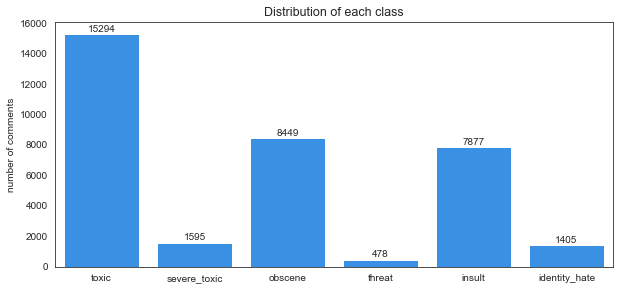

In [30]:
# plot bar charts to show the occurence number of each label class
plt.figure(figsize = (10,4.5))
class_data = df.iloc[:, 2:8]
ax = sns.barplot(list(class_data.columns), class_data.sum(), color = 'dodgerblue')
plt.title("Distribution of each class", fontsize = 12.5)
plt.ylabel("number of comments")
rects = ax.patches
total = class_data.sum()
for rect, total in zip(rects, total):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, total, ha='center', va='bottom')

In [31]:
totals = class_data.count()
positives = [i/j*100 for i, j in zip(class_data.sum(), totals)]
non_label = class_data.count() - class_data.sum()
nagatives = [i/j*100 for i, j in zip(non_label, totals)]

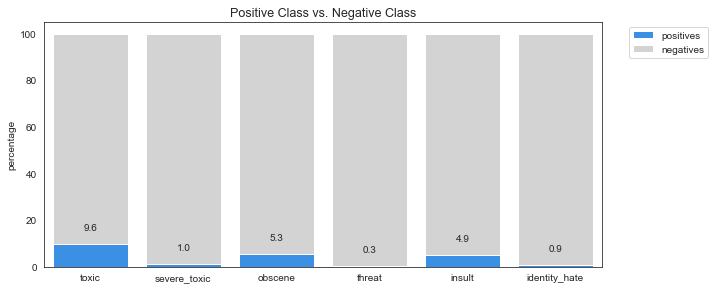

In [32]:
# Plot 100% stacked bar chart to show the imbalance between positive and negative instances
plt.figure(figsize = (10,4.5))
ax1 = sns.barplot(list(class_data.columns), positives, label ='positives', color = 'dodgerblue')
ax2 = sns.barplot(list(class_data.columns),nagatives, bottom= positives, label = 'negatives',  color = 'lightgray')
plt.legend(bbox_to_anchor = (1.2, 1),loc='upper right')
plt.title("Positive Class vs. Negative Class", fontsize = 12.5)
plt.ylabel("percentage")
#adding the text labels
rects = ax1.patches
labels = [round(positive,1) for positive in positives]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

**what's the co-occurence rate of the labels? (How do they occur together?)**

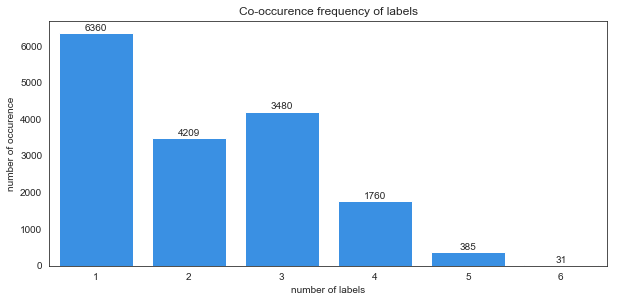

In [33]:
# count the co-occurene frequency of the labels
df['colabeling'] = class_data.sum(axis=1)
colabeling = df['colabeling'].value_counts()
plt.figure(figsize = (10,4.5))
# ignore the ones without any labels
ax = sns.barplot(colabeling.index[1:], colabeling.values[1:], color = 'dodgerblue')
plt.title('Co-occurence frequency of labels')
plt.xlabel('number of labels')
plt.ylabel('number of occurence')
# adding the text labels on chart
rects = ax.patches
labels = colabeling.values[1:]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

**What words are most mentioned in each class?**

In [34]:
# prepare comment of each class for creating wordcloud image
toxic = " ".join(comment for comment in df.loc[df['toxic'] == 1, 'clean_comment'])
severe_toxic =  " ".join(comment for comment in df.loc[df['severe_toxic'] == 1, 'clean_comment'])
obscene = " ".join(comment for comment in df.loc[df['obscene'] == 1, 'clean_comment'])
threat = " ".join(comment for comment in df.loc[df['threat'] == 1, 'clean_comment'])
insult = " ".join(comment for comment in df.loc[df['insult'] == 1, 'clean_comment'])
identity_hate = " ".join(comment for comment in df.loc[df['identity_hate'] == 1, 'clean_comment'])

In [35]:
toxic_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(toxic)
severe_toxic_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(severe_toxic)
obscene_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(obscene)
threat_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(threat)
insult_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(insult)
identity_hate_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(identity_hate)

(<matplotlib.axes._subplots.AxesSubplot at 0x1a2ed18438>,
 (-0.5, 399.5, 199.5, -0.5),
 Text(0.5, 1.0, 'identity_hate'))

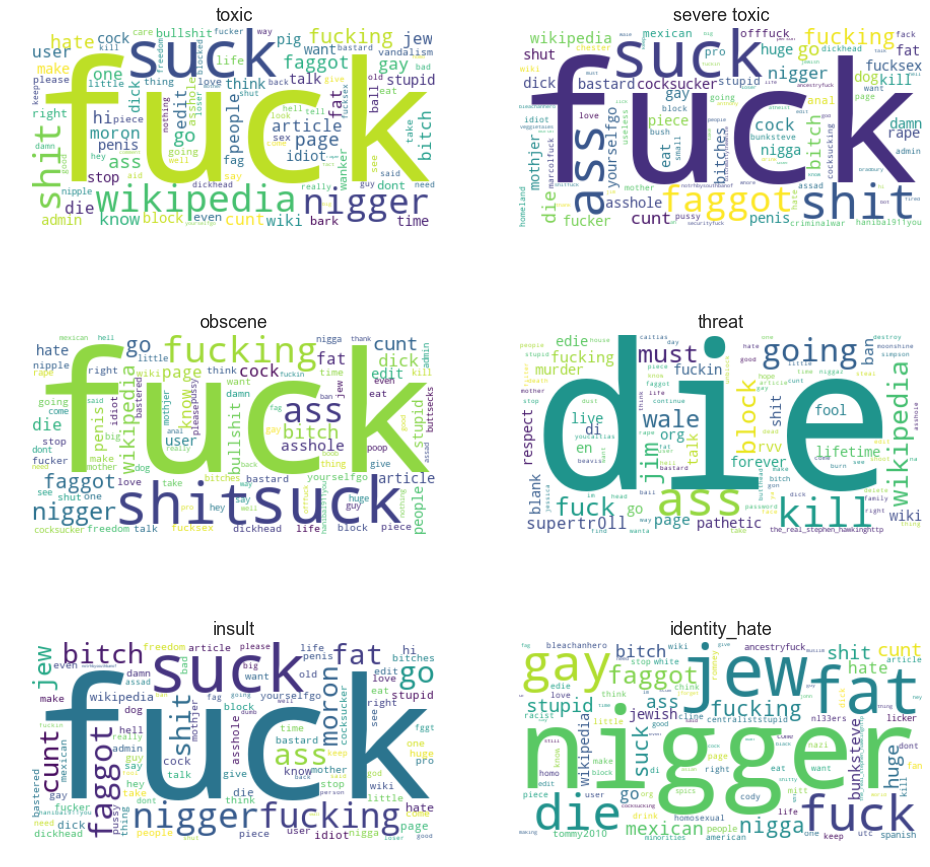

In [36]:
# plot wordcloud image for 6 class
fig=plt.figure(figsize=(16, 16))
plt.subplot(3,2,1), plt.imshow(toxic_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('toxic', fontsize=18)
plt.subplot(3,2,2), plt.imshow(severe_toxic_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('severe toxic', fontsize=18)
plt.subplot(3,2,3), plt.imshow(obscene_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('obscene', fontsize=18)
plt.subplot(3,2,4), plt.imshow(threat_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('threat', fontsize=18)
plt.subplot(3,2,5), plt.imshow(insult_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('insult', fontsize=18)
plt.subplot(3,2,6), plt.imshow(identity_hate_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('identity_hate', fontsize=18)

**How to separate the 6 groups based on dictionary definition**
- toxic: "Very harmful or unpleasant in a pervasive or insidious way", "extremely harsh, malicious, or harmful"
- obscene: "containing or being language regarded as taboo in polite usage", "connected with sex in a way that most people find offensive", "(of the portrayal or description of sexual matters) offensive or disgusting by accepted standards of morality and decency"
- threat: "an expression of intention to inflict evil, injury, or damage", "a statement in which you tell somebody that you will punish or harm them, especially if they do not do what you want"
- insult:"to affect offensively or damagingly", "A disrespectful or scornfully abusive remark or act"
- identity hate: "abusive or threatening speech or writing that expresses prejudice against a particular group, especially on the basis of race, religion, or sexual orientation"


**Initial Findings From WordCloud**
- Since it is a multi-class dataset, which means that, one comment might get more than one labels, keywords such as "fuck" and "suck" are commonly seen across different groups.
- Though the keywords seem to be similar among groups at first glance, "obscene" class is highly associated with sex-related words, "threat" is related to physical-abuse words, "identity hate" is associated with race and gender identity.

# Train/Test Split
- Do train/test split before vectorization to simulate the real world situation in which unseen words happen and should be dropped. Testing set carries the simulation role, that is, carrying words that are unseen in the training. Text in the testing set should not be included in the copus vectorization.

In [37]:
# split the data into training and test
train, test = train_test_split(df, random_state = 0, test_size=0.2, shuffle=True)

In [38]:
X_train = train['clean_comment']
X_test = test['clean_comment']

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Text Feature Extraction
- Text content has to be converted into numerical feature vectors before feeding to machine learning algorithms, which only accept numerical input.
- `Bag-of-Words` and `TF-IDF` are common text representation that treat each the occurence frequency of individual token as feature.

**Limitation** : `Bag-of-Words` and `TF-IDF` ignore the semantic relationship between words because they don't consider the oder.

### Bag-of-Word Representation
- Bag-of-Word (BOW) counts how many times a word appears in a document. It transforms the corpus of documents into a big matrix of token counts. Each row is per document and each column is the occurence frequency per token.
- Words that don't appear in the corpus will not be represented.

In [39]:
# # use BOW to tokenize and count the word occurences of a mini corpus
# mini_corpus = df['clean_comment'].sample(n = 1, random_state = 0)
# print (mini_corpus)
# vectorizer = CountVectorizer()
# X = vectorizer.fit_transform(mini_corpus)
# # BOW matrix
# X.toarray()

### TF-IDF Term Weighting¶
- TF-IDF (Term Frequency - Inverse Document Frequency) add weights to words according to their relevant importance. The purpose is to highlight the weights of unique words, which should be more representative than repetitive words such as "the" and "a" ect.
- TF calculates the occurence frequency of a word in a single document, and IDF measures how often a word appears in all documents. 

In [40]:
# initialize a vectorizer
vectorizer = TfidfVectorizer()
# transform the training dataset
train_text = vectorizer.fit_transform(X_train)

**IDF value tells corpus-specific stopwords**
- Idf value is the part to scale down frequent words with less information and highlight rare words being more rarely and hense more representative of the content of the documents. Each word has a fixed idf value across corpus and can be examined with _idf attribute. Words with low IDF value are viewed as corpus-specific stopwords.

In [41]:
feature_name = np.array(vectorizer.get_feature_names())
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(feature_name[sorted_by_idf][:30]))

Features with lowest idf:
['article' 'page' 'talk' 'wikipedia' 'would' 'please' 'like' 'one' 'see'
 'also' 'think' 'know' 'edit' 'time' 'people' 'articles' 'thanks' 'may'
 'get' 'make' 'even' 'good' 'use' 'well' 'could' 'want' 'way' 'thank'
 'need' 'first']


- Since the corpus is built from wikipedia comments, it is understandable why "article", "page", "talk", and "wikipedia" carry less values.

**TFIDF value tells words with larger influence on models**
- Tfidf value of same word changes across documents, since it is decided not only by the idf value but also its frequency count in that document. To inspect the overall insights, it is better to get the average tfidf value per word and examine the ones with the highest/lowest value.

In [42]:
# take the average of all rows in each column
tfidf_mean = train_text.mean(axis=0)

In [43]:
tfidf_mean.shape

(1, 170204)

In [44]:
# map every average tfidf value to the term it represents
tfidf_mean_series = pd.Series(np.ravel(tfidf_mean), index = feature_name  )

In [45]:
# words with highest tfidf value in average
tfidf_mean_series.nlargest(20)

article      0.019298
talk         0.018821
page         0.018437
wikipedia    0.016537
please       0.014895
would        0.013344
like         0.011413
one          0.010778
thanks       0.010513
edit         0.009875
see          0.009639
know         0.009439
think        0.009329
articles     0.007939
also         0.007908
people       0.007499
user         0.007422
get          0.007318
time         0.007268
use          0.007229
dtype: float64

In [46]:
# words with lowest tfidf value in average
tfidf_mean_series.nsmallest(20)

nipp                                                                                                           1.297593e-08
aidsai                                                                                                         1.541586e-08
dienew                                                                                                         1.944975e-08
mahonerz                                                                                                       2.327072e-08
mahy                                                                                                           2.327072e-08
alllllllllllllllllllllllllllllll                                                                               3.052128e-08
blck                                                                                                           3.052128e-08
fukerssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss    3.052128e-08
retrn   

- Top words with overall highest tfidf value overlap with words with least idf value. It is different that what I initially expected: using high tfidf words to identify toxic-related key words. The result is probably because the dataset is imbalanced with majority data being nontoxic. Words with higher tfidf values are said to have larger influence on the model, but the model prediction result cannnot be decided by any single word. The probability of a comment being classified to which label is decided by the combination of weights computed by each words in that comment.
- Samller tfidf value means that the frequency of a word frequency is very low. Thus, words with lease tfidf value are probably just noise.

# Modelling

### Define Problem
**Multi-label classification problem instead of Multi-class problem** 
- Multi-label classification:  Each comment can be assigned to more than one labels. It is expressed with label binary indicator array.
- Multi-class classification: There are more than two kinds of labels but each sample can only have one and only one label. 

### Decide Metrics
**Evaluation Metric**
The Kaggle Competition requires to use ROC AUC to evaluate the model performance, which is particularly good at binary classification problem. 
ROC Curve is a common way to visualize the trade off of TPR and FPR when applying different threshold. It is incensitive to unbalanced dataset and can also help to find the optimal threshold. AUC can provide a single value to help us quickly compare the differnece performance of each classification model.

**Other possible metrics to consider** 
(open to edit)

### Decide Solutions
- Models that are good at handling classification problems such as logitic regression, naive bayes, and SVM etc will be used.
- The baseline model is logistic regression with bigram starting from raw text data.

**Comments**: As we can notice, since the text are Wikipedia corpus, "article", "page", "talk" are commonly used words that are frequently seen in each comments and thus are less infromatative and have low idf value.

## Build Multi-Label Classifier

Only with evaluation of suitable metrics can a model’s performance be trustworthy. Thinking though the nature of the dataset and the stakeholders’ interests about the prediction paves the way for selecting appropriate metrics and further judging a model good or bad without bias.

**What’s the nature of toxic comment dataset?**
- The dataset is imbalanced because the instances of non-toxic (Negative) are much more than toxic (Positive) for each class.  `Accuracy`, in this case, is not a suitable metrics. Takes “threat class” as an example. The instances of threat and non-threat are 478 and 143346. A non-skill model that predicts every comments as non-threat can guess right almost every time and acheive 0.997 accuracy, yet is incapable of predicting which is threat and which is not. 

**What’s the possible outcome and cost when misclassification happen?**
- Imagine two scenarios: First, if our system incorrectly identifies a neutral comment as toxic (False Positive), and Wikipedia believing the prediction decides to delete the comment and even block the user account . The consequence is costly, because the user who doesn’t do anything wrong might get irritated and refuses to contribute to Wikipedia forever.
- Another is if our system incorrectly identifies a toxic comment as normal (False Negative), and Wikipedia believing the prediction takes no action. The toxic message is shown online until someone finds its inappropriate and reports the system. The cost of misclassification is low. 
- Pondering the possible outcome and cost of misclassification, the penalty of False Positive should be higher than False Negative in our case. 

**Which metrics are more suitable considering the dataset being imbalanced and the penalty of False Positive is higher?**

`Precision-Recall`: 
- Precision and recall both focuses on positive class, ignoring True Negatives, which is the major class in toxic project. Thus, they are insensitive to the imbalanced data. Since we care more about False Positive than False Negative, we should go for methods with higher precision and low recall.

`ROC AUC`: 
- ROC measure the model’s ability to distinguish Positive and Negative class, because it considers True Positive (what we want) and False Positive (what we want to reduce). And AUC summarizes the performance into single number, making it easier to compare between models. It doesn’t hold the assumption of the class distribution, thus it is generally good for dealing with imbalanced dataset. ROC AUC is also the metric used in Kaggle competition.


In summary, we'll adopt Precision, Recall and ROC AUC as the evaluation metrics and we'll look for models with high precision and low recall, and also higher ROC AUC. 

### Baseline Model: Logistic Regression
Here, I use Logistic Regression with bigrams and tfidf extracting text features as baseline models.

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [48]:
# evaluation metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [49]:
# apply sklearn pipeline to build logistic regression model 
# vectorize text using bag-of-bigrams representation
# use OneVsRest strategy

lr_pipeline = Pipeline([('bow', CountVectorizer(ngram_range = (1, 2))), 
                            ('clf', OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter = 1000), n_jobs=1)),
            ])
# solver can change to lbfgs
# max_iter: 100 - 1000

auc = []
f1 = []
for label in labels:
    print('... Processing {}'.format(label))
    # train the model using X_train & y
    lr_pipeline.fit(X_train, train[label])
    # compute the testing score
    pred_y_test = lr_pipeline.predict(X_test)
    auc.append(roc_auc_score(test[label], pred_y_test))
    f1.append(f1_score(test[label], pred_y_test))
    print('ROC_AUC score is {}'.format(roc_auc_score(test[label], pred_y_test)))
    print('Precision score is {}'.format(precision_score(test[label], pred_y_test)))
    print('Recall score is {}'.format(recall_score(test[label], pred_y_test)))
    print('Accuracy score is {}'.format(accuracy_score(test[label], pred_y_test)))

print('mean column-wise ROC AUC:', np.mean(auc))
print('mean column-wise f1 score:', np.mean(f1))

... Processing toxic
ROC_AUC score is 0.8239632875800929
Precision score is 0.8770421324161651
Recall score is 0.6578523057078361
Accuracy score is 0.9577941406861977
... Processing severe_toxic
ROC_AUC score is 0.6322031114165658
Precision score is 0.4756756756756757
Recall score is 0.2674772036474164
Accuracy score is 0.9894093686354379
... Processing obscene
ROC_AUC score is 0.8386660595154024
Precision score is 0.8682634730538922
Recall score is 0.6831566548881036
Accuracy score is 0.9776280745730848
... Processing threat
ROC_AUC score is 0.6312868095956331
Precision score is 0.39344262295081966
Recall score is 0.26373626373626374
Accuracy score is 0.9967413441955193
... Processing insult


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


ROC_AUC score is 0.7725069485488957
Precision score is 0.7777777777777778
Recall score is 0.5533249686323714
Accuracy score is 0.9697947673507755
... Processing identity_hate
ROC_AUC score is 0.6244788983413688
Precision score is 0.4658385093167702
Recall score is 0.2516778523489933
Accuracy score is 0.9903180322732258
mean column-wise ROC AUC: 0.7205175191663264
mean column-wise f1 score: 0.5246817592453357


In [50]:
# TF-IDF
lr_pipeline_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter = 1000), n_jobs=1)),
            ])

auc = []
f1 = []
for label in labels:
    # train the model using X_train & y
    lr_pipeline_tfidf.fit(X_train, train[label])
    # compute the testing scores
    pred_y_test = lr_pipeline_tfidf.predict(X_test)
    print('ROC_AUC score is {}'.format(roc_auc_score(test[label], pred_y_test)))
    auc.append(roc_auc_score(test[label], pred_y_test))
    f1.append(f1_score(test[label], pred_y_test))
print('mean column-wise ROC AUC:', np.mean(auc))
print('mean column-wise f1 score:', np.mean(f1))

ROC_AUC score is 0.7904191663342557
ROC_AUC score is 0.611496388400309
ROC_AUC score is 0.8071256700599858
ROC_AUC score is 0.5493405695611578
ROC_AUC score is 0.7479562988031411
ROC_AUC score is 0.5951631555787357
mean column-wise ROC AUC: 0.6835835414562642
mean column-wise f1 score: 0.47690926577004694


**Comments on baseline model**
- Since Tfidf shows the higher score, I choose to use tfidf as the text feature extraction method. 

### Other Models without Parameter Tuning

In [51]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

**Naive Bayes**

In [52]:
# TF-IDF

NB_pipeline_tfidf = Pipeline([('tfidf', TfidfVectorizer()),
                              ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),])

auc = []
f1 = []
for label in labels:
    # train the model using X_dtm & y
    NB_pipeline_tfidf.fit(X_train, train[label])
    # compute the testing scores
    pred_y_test = NB_pipeline_tfidf.predict(X_test)
    print('ROC_AUC score is {}'.format(roc_auc_score(test[label], pred_y_test)))
    auc.append(roc_auc_score(test[label], pred_y_test))
    f1.append(f1_score(test[label], pred_y_test))
print('mean column-wise ROC AUC:', np.mean(auc))
print('mean column-wise f1 score:', np.mean(f1))

ROC_AUC score is 0.591174120207027
ROC_AUC score is 0.4999841702019882
ROC_AUC score is 0.5585652570474432
ROC_AUC score is 0.5054945054945055
ROC_AUC score is 0.5212310461251559
ROC_AUC score is 0.4999841857228706
mean column-wise ROC AUC: 0.5294055474664984
mean column-wise f1 score: 0.10352279354899104


**Comment on Naive Bayes:**
Multinomial Naive Bayes expects integer inputs, so it might work better with CountVectorizer than TfidfVectorizer which comes with weighted inputs.

**SVM**

In [53]:
from sklearn.svm import LinearSVC

SVC_pipeline = Pipeline([('tfidf', TfidfVectorizer()), 
                            ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

auc = []
f1= []

for label in labels:
    # train the model using X_train & y
    SVC_pipeline.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = SVC_pipeline.predict(X_test)
    print('ROC_AUC score is {}'.format(roc_auc_score(test[label], pred_y_test)))
    auc.append(roc_auc_score(test[label], pred_y_test))
    f1.append(f1_score(test[label], pred_y_test))
print('mean column-wise ROC AUC:', np.mean(auc))
print('mean column-wise f1 score:', np.mean(f1))

ROC_AUC score is 0.83907269494184
ROC_AUC score is 0.6414166312380711
ROC_AUC score is 0.8519665838382307
ROC_AUC score is 0.5877549737843856
ROC_AUC score is 0.7766514253158291
ROC_AUC score is 0.6335165454486404
mean column-wise ROC AUC: 0.7217298090944994
mean column-wise f1 score: 0.5364355557712978


**Decision Tree**

In [54]:
from sklearn.tree import DecisionTreeClassifier
dt_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier()),])

auc = []
f1=[]

for label in labels:
    # train the model using X_train & y
    dt_pipeline.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = dt_pipeline.predict(X_test)
    print('ROC_AUC score is {}'.format(roc_auc_score(test[label], pred_y_test)))
    auc.append(roc_auc_score(test[label], pred_y_test))
    f1.append(f1_score(test[label], pred_y_test))
print('mean column-wise ROC AUC:', np.mean(auc))
print('mean column-wise f1 score:', np.mean(f1))

ROC_AUC score is 0.8326421491917368
ROC_AUC score is 0.6295910985148474
ROC_AUC score is 0.869851838875869
ROC_AUC score is 0.6257608812755872
ROC_AUC score is 0.7989454493134255
ROC_AUC score is 0.6553301649588308
mean column-wise ROC AUC: 0.7353535970217161
mean column-wise f1 score: 0.5033088612413396


**Ensemble Classifier: Random Forest**

In [55]:
from sklearn.ensemble import RandomForestClassifier
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier()),])

auc = []
f1 = []

for label in labels:
    # train the model using X_train & y
    rf_pipeline.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = rf_pipeline.predict(X_test)
    print('ROC_AUC score is {}'.format(roc_auc_score(test[label], pred_y_test)))
    auc.append(roc_auc_score(test[label], pred_y_test))
    f1.append(f1_score(test[label], pred_y_test))
print('mean column-wise ROC AUC:', np.mean(auc))
print('mean column-wise f1 score:', np.mean(f1))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ROC_AUC score is 0.7644554784059407
ROC_AUC score is 0.5405902003061261
ROC_AUC score is 0.7896958856653404
ROC_AUC score is 0.5164206708324356
ROC_AUC score is 0.6992708756580622
ROC_AUC score is 0.5567306943231839
mean column-wise ROC AUC: 0.6445273008651814
mean column-wise f1 score: 0.38276830741699186


### Tuning Top-Performed Models: Logistic Regression
- We select the two top-performned models to tune their parameters and tfidf vecotrizer. Decision tree has the highest ROC AUC score. (explanation open to add)
- SVM model ranks second among models, yet its ROC AUC score(0.72) is close to Logistic Regression (0.68). It is natual to for us to choose the simpler model, in this case Logistic Regression, which achieves similar performance.

In [56]:
from sklearn.model_selection import GridSearchCV

In [57]:
# Logistic hyper parameter tuning
lr_pipeline_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', OneVsRestClassifier(LogisticRegression(solver = 'lbfgs',max_iter = 1000))),
            ])
lr_param = {'clf__estimator__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], # control regularization to avoid overfitting or underfitting
            'clf__estimator__penalty': ['l2']} 

lr_grid_search = GridSearchCV(lr_pipeline_tfidf, param_grid = lr_param, cv=3, scoring='roc_auc')

lr_grid_search.fit(X_train, train[labels])
print ('Best score: %0.3f' % lr_grid_search.best_score_)
print ('Best paramters set:', lr_grid_search.best_params_)


Best score: 0.977
Best paramters set: {'clf__estimator__C': 1, 'clf__estimator__penalty': 'l2'}


In [58]:
# Apply optimized logistic regression on test dataset

lr_optimized = Pipeline([('tfidf', TfidfVectorizer()), 
                        ('clf', OneVsRestClassifier(LogisticRegression(solver = 'lbfgs', C = 1, penalty = 'l2',max_iter = 1000))),
                         ])
auc = []
f1 = []

for label in labels:
    # train the model using X_train & y
    lr_optimized.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = lr_optimized.predict(X_test)
    auc.append(roc_auc_score(test[label], pred_y_test))
    f1.append(f1_score(test[label], pred_y_test))
print('mean column-wise ROC AUC:', np.mean(auc))
print('mean column-wise f1 score:', np.mean(f1))

mean column-wise ROC AUC: 0.6835835414562642
mean column-wise f1 score: 0.47690926577004694


In [59]:
#fuck = 'fuck'
#lr_optimized.fit(X_train, train['toxic'])
#lr_optimized.predict_proba(fuck)[:, 1]

### Examing ROC AUC Curve

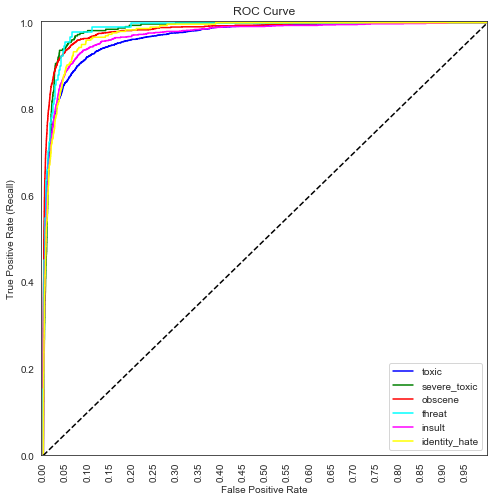

In [60]:
# Plot 6 ROC AUC curves respectively for 6 binary classification problems
from sklearn.metrics import roc_curve
plt.figure(figsize=(8,8))
colors = ["blue", "green", "red", "cyan", "magenta", "yellow"]
i = 0
for label in labels:
    y_prob = lr_optimized.fit(X_train,train[label]).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(test[label],y_prob)
    plt.plot(fpr, tpr, label = label, color = colors[i])
    i += 1
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0,1, 0.05), rotation=90)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc='best')

**Comments on the ROC AUC curve for logistic regression**:
> ROC AUC curve tells how a model is capable of distinguishing between classes. ROC curve shows the trade-off between TPR on y-axis and FPR on x-axis. Top left corner is the sweet spot where TPR is maximized and FPR is minimized. AUC score measures a model's separation ability. It represents the probability that the model ranks a random positive example more highly than a random negative example.

- Above plot shows the good overall performance of the model with each curve close toward the top left corner. The average AUC score for 6 separate binary classifiers is 0.683, **meaning that averagely there is 68% chance that model can distinguish between positive class and negative class.** 
- Among 6 classes, threat and server toxic perform the best while toxic class has more room for improvement.

### Choosing Optimal Threshold

If taking *business context* into consideration when using evaluation metrics, precision and recall are more suitble than ROC AUC.

I decide to take a closer examination on the "toxic" class and choose a threshold that balances precision and recall in a way that makes sense for this business context where the cost of False Positive is higher than that of False Negative.

In [61]:
from sklearn.metrics import confusion_matrix
toxic_pred = lr_optimized.fit(X_train, train['toxic']).predict(X_test)
# auc score
print (roc_auc_score(test['toxic'], toxic_pred))

0.7904191663342557


In [62]:
# confusion matrix when threshold set to be 0.5 by default
print (confusion_matrix(test['toxic'], toxic_pred))
tn, fp, fn, tp = confusion_matrix(test['toxic'], toxic_pred).ravel()
print ('precision: {}'.format(tp / (fp + tp)))

[[28667   147]
 [ 1284  1817]]
precision: 0.925152749490835


In [63]:
# manual check the trade-ff between precision and recall at different threshold value
y_pred_prob = lr_optimized.fit(X_train, train['toxic']).predict_proba(X_test)[:, 1]
threshold_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in threshold_list:
    y_pred_toxic = (y_pred_prob > i)*1
    tn, fp, fn, tp = confusion_matrix(test['toxic'], y_pred_toxic).ravel()
    precision = tp / (fp + tp)
    recall = tp / (fn+ tp)
    print (i, precision, recall)

0.1 0.5507189285010833 0.9016446307642696
0.2 0.7469005140610826 0.7965172524991938
0.3 0.8413298073290517 0.7181554337310545
0.4 0.8876651982378855 0.6497903901967107
0.5 0.925152749490835 0.5859400193485972
0.6 0.9532983070636311 0.526604321186714
0.7 0.9636963696369637 0.4708158658497259
0.8 0.9746268656716418 0.4211544663011932
0.9 0.9897196261682243 0.34150274105127376


**Decision on optimal threshold**:
- The default threshold at 0.5 has already provided good precision score at 0.93. We can be very confident to trust the result when model predicts a sample Positive. The high precision reduces the risk when we take a suspected comment down from the platform, while it is indeed neutral.
- 0.4 gives a good balance between precision and recall. While we don't want to piss off the user due to misalarm, we don't want to miss capturing toxic messages and cause negative impact on user behaviors. Thus, 0.4 is the recommended threshold value.

### Manual Inspecting Misclassification

In [64]:
print (X_test.shape)
print (test['toxic'].shape)
print (y_pred_prob.shape)
print (toxic_pred.shape)

(31915,)
(31915,)
(31915,)
(31915,)


In [65]:
error_df = pd.DataFrame({'test_text':np.array(X_test),'prob':y_pred_prob, 
             'real_class':np.array(test['toxic']), 'pred_class':toxic_pred})

In [66]:
# create a dataframe for manual error examination
error_df.head()

,test_text,prob,real_class,pred_class
0,paraphrased gary complained preferring recent ...,0.013910,0,0
1,blocked revers blocked revers blocked revers b...,0.040183,1,0
2,sorry would like unreservedly retract previous...,0.422637,0,0
3,know exactly like press release use source htt...,0.021492,0,0
4,thank improve wikipedia 2007 dear thanks warm ...,0.015262,0,0


**false alarm**

In [67]:
fp_df = error_df.loc[error_df['pred_class'] > error_df['real_class']].sort_values(by = ['prob'], ascending=True)
fp_df.head()

,test_text,prob,real_class,pred_class
29354,oh see yall jelous cause yall bunch yankees im...,0.501642,0,1
18486,psychological problems advice dude looking ext...,0.502282,0,1
25962,would argue whitemanners seriously disturbed i...,0.502987,0,1
25850,least castro trying liberate cuba us dominatio...,0.503230,0,1
23441,neutral big violation refuses talk without inv...,0.504794,0,1


**miss detection**

In [68]:
fn_df = error_df.loc[error_df['pred_class'] < error_df['real_class']].sort_values(by = ['prob'], ascending=False)
fn_df.head()

,test_text,prob,real_class,pred_class
26323,axeman 10 says vandalize ac dcs page perform s...,0.499804,1,0
158,666 2x holy 333 trinity repent bastard,0.499435,1,0
2289,unblock prick yeah,0.499227,1,0
3466,wtf man every edit made blindly reverted olahu...,0.498281,1,0
17423,hum pig,0.498226,1,0


### Tuning Top-Performed Models: Decision Tree

In [69]:
# Decision Tree hyper-parameter tuning

from sklearn.model_selection import RandomizedSearchCV

pipeline_dt = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier()),])

dt_param = {'tfidf__max_features': [10000, 30000], # limit the amoung of features(vocabularly) that the vectorizer will learn
                'tfidf__max_df' : [0.5, 0.75], # ignore terms that have a document frequency higher than threshold 
                'clf__max_depth': range(5,10), # control the depth of the tree to avoid overfitting problem
             } 

dt_grid_search = GridSearchCV(pipeline_dt, param_grid = dt_param, cv=3, scoring='roc_auc')

dt_grid_search.fit(X_train, train[labels])
print ('Best score: %0.3f' % dt_grid_search.best_score_)
print ('Best paramters set:', dt_grid_search.best_params_)

Best score: 0.750
Best paramters set: {'clf__max_depth': 9, 'tfidf__max_df': 0.75, 'tfidf__max_features': 30000}


In [70]:
# Apply optimized logistic regression on test dataset
dt_optimized = Pipeline([
    ('tfidf', TfidfVectorizer(max_df = 0.75, max_features = 30000)),
    ('clf', DecisionTreeClassifier(max_depth = 9)),])
auc = []

for label in labels:
    print('... Processing {}'.format(label))
    # train the model using X_train & y
    dt_optimized.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = dt_optimized.predict(X_test)
    print('ROC_AUC score is {}'.format(roc_auc_score(test[label], pred_y_test)))
    auc.append(roc_auc_score(test[label], pred_y_test))
print('mean column-wise ROC AUC:', np.mean(auc))

... Processing toxic
ROC_AUC score is 0.6990512624566864
... Processing severe_toxic
ROC_AUC score is 0.5630541271314655
... Processing obscene
ROC_AUC score is 0.8049681606150532
... Processing threat
ROC_AUC score is 0.5546622495151907
... Processing insult
ROC_AUC score is 0.755239710919179
... Processing identity_hate
ROC_AUC score is 0.6050246840700133
mean column-wise ROC AUC: 0.6636666991179314


Other workflow: Tune Tfidf Vectorizer first and apply it to each model

# Advanced Feature Engineering: Word2Vec
**Shortcoming of count-based models**
- Previously, I used count-based models, Bag-of-Words and Tfidf, for feature engineering, which ended with descent result. However, these models fail to capture the contextual relationship among words and often requires large copora due to its nature of high-dimensional sparce vector. 

**The need for wordembeddings: Word2Vec**
- One way to solve the above issue is word embeddings, which can capture the semantic relationship. Here, I'm applying Word2Vec features for the classification task to see if better score can be achieved.

In [71]:
# import gensim
from gensim.models import word2vec

In [72]:
# tokenize the normalized training corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(comment) for comment in X_train]

In [75]:
# build word2vec model
from gensim.models import Word2Vec
w2v = Word2Vec(tokenized_corpus, 
               size = 100, # word vector dimensionality 
               window = 5, # context window size    
               min_count = 10, 
               workers = 4)

In [76]:
# sample word embedding
w2v.wv['wikipedia']

array([ 1.3822674 , -1.9443018 , -1.9668553 , -0.4721427 ,  1.4127331 ,
        2.3054986 ,  0.45884392, -0.4318424 , -1.329933  ,  1.2579238 ,
       -0.64202535, -1.3573941 ,  0.5352069 , -1.2194365 ,  0.79261476,
       -0.6506354 , -0.0844835 ,  0.32369468,  0.7829473 ,  1.890816  ,
        0.9650877 ,  1.5072563 ,  1.1195413 , -1.2703828 , -0.31015012,
        1.5457768 ,  1.5625296 ,  0.32616076, -0.8343905 ,  1.4432108 ,
        0.55218714, -1.4399364 ,  0.6481888 , -1.1106594 ,  1.378403  ,
        0.7415557 ,  1.2334214 , -0.6782829 , -0.10713291,  0.7134095 ,
        0.431728  , -0.6036585 , -2.718716  ,  0.5094105 , -0.8689269 ,
        0.04287435, -1.3641766 ,  2.121535  , -1.0213497 ,  0.05022394,
        0.4140411 , -1.3344302 , -0.3570354 , -1.0658088 ,  0.47737813,
       -0.34642676,  0.98063076,  0.5058856 , -0.69439334, -0.6805713 ,
        2.0955312 , -1.9620335 ,  0.4045646 , -1.8565897 , -0.23516297,
        1.302257  ,  1.3727872 , -1.8364304 , -2.1802135 , -1.54

In [77]:
# look for similarities among words
w1 = 'wikipedia'
w2v.wv.most_similar(positive = w1, topn = 10)

[('wiki', 0.6707632541656494),
 ('wikipedias', 0.5878428220748901),
 ('encyclopedia', 0.5362579822540283),
 ('wikis', 0.49603936076164246),
 ('encyclopaedia', 0.48192664980888367),
 ('enforcing', 0.47983571887016296),
 ('project', 0.46709465980529785),
 ('wp', 0.46694499254226685),
 ('guidelines', 0.46641045808792114),
 ('policies', 0.45731258392333984)]

In [78]:
# visualize
# Problem: long running time

### Document-level of word embeddings
- Word2Vec model trained on the training text generates a multi-dimensional vector per uniqe word. To apply it to extract feature of each wikipedia comment, we need to produce document-level embeddings. The process ensures that each input (numerical representation of a comment) fitting to the model shares same dimension.
- One way to get document-level embeddings is to average out the Word2Vec of each word in a comment. For example, if we have 3 words in a sentence. We'll need to add up 3 100-dimensional vectors and divide it by 3 to get a final vector, representing the sentence.

In [ ]:
# document level of word embedding

In [79]:
def average_vector(sentence, model, vocabulary, vector_dimension):
   
    """add up the vector computed from w2v model of each word from a sentence,
    and divide values by the sentence length to get an average word vector"""
    
    feature_vector = np.zeros(vector_dimension) #initialize an empty matrix with the same size as the vector dimension
    len_sentence = 0 #calculate the length of a sentence
    for word in sentence:
        if word in vocabulary: #in case there are unseen words in the training set
            len_sentence += 1
            feature_vector = np.add(feature_vector, model[word]) #add the vector dimension to the matrix
    
    if len_sentence != 0:
        feature_vector = np.divide(feature_vector, len_sentence)
    
    return feature_vector

In [80]:
def averaged_word_vectorizer(corpus, model, vector_dimension):
    vocabulary = set(model.wv.index2word)
    features = [average_vector(tokenized_sentence, model, vocabulary, vector_dimension)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [81]:
w2v_feature_df = pd.DataFrame(averaged_word_vectorizer(tokenized_corpus, w2v, 100))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [82]:
w2v_feature_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.953158,0.688822,-0.154805,-0.018748,0.127503,0.322573,-0.154931,-0.477517,0.262936,0.786187,...,0.808537,0.051509,-0.224770,-0.359792,-0.319401,0.241802,0.568642,-0.390277,0.251662,1.291083
1,-0.658408,-1.341217,-0.286351,0.750496,1.015445,-0.228165,0.713979,-1.506185,-0.644416,0.099375,...,0.215092,-0.472058,0.426090,-0.460292,-0.088445,-0.719169,1.189839,0.362348,0.488714,0.783163
2,0.081732,-0.219532,-0.337318,0.051293,-0.152316,0.413186,-0.308000,0.276457,0.270609,0.576066,...,0.155529,0.312115,0.310221,-0.466141,-0.293404,-0.383023,-0.161121,0.509014,0.165221,0.672565
3,0.233207,-0.480370,-0.287449,-0.234675,0.064659,0.034388,0.092702,-0.494311,0.182865,0.112545,...,0.415841,-0.261219,0.495240,-0.227366,0.017947,-0.147700,0.422576,0.046030,0.209469,0.796114
4,-0.094682,-0.847918,-1.232227,-0.511415,0.074865,-0.263140,0.382918,-0.480116,0.348105,0.443365,...,-0.148992,0.753872,1.125656,-1.299159,0.980443,-0.258927,0.556218,-0.236439,0.659284,1.158628


In [83]:
w2v_feature_df.shape

(127656, 100)

In [84]:
X_train.shape

(127656,)

### Apply Word2Vect to Machine Learning

In [ ]:
# train the machine learning model: logistic regression, with w2v feature


In [ ]:
# test on the testing set